# **Data Collection and Preparation**

In [116]:
# Import necessary libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

In [117]:
# Load the Dataset.

sales_data = pd.read_csv('/content/product_sales_data (2).csv')

sales_data

,Product_ID,Sales_Date,Region,Category,Price,Quantity_Sold,Revenue,Cost
0,P0009,2023-03-08,West,Furniture,440.58,2,881.16,606.31
1,P0003,2023-11-20,East,Toys,141.59,5,707.95,423.49
2,P0017,2023-03-05,East,Clothing,124.14,14,1737.96,1179.19
3,P0008,2023-11-26,South,Sports,183.61,10,1836.10,758.51
4,P0001,2023-04-26,South,Sports,284.15,2,568.30,375.25
...,...,...,...,...,...,...,...,...
49995,P0018,2023-10-15,East,Clothing,132.95,13,1728.35,734.16
49996,P0007,2023-04-18,West,Furniture,333.62,14,4670.68,2937.73
49997,P0013,2023-07-10,North,Toys,149.30,2,298.60,198.59
49998,P0004,2023-09-02,South,Clothing,181.13,10,1811.30,1249.53


In [118]:
sales_data['Sales_Date'] = pd.to_datetime(sales_data['Sales_Date'])  # Converted the 'Sales_Date' column to datetime format

In [119]:
sales_data.info()  # Displayed basic information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Product_ID     50000 non-null  object        
 1   Sales_Date     50000 non-null  datetime64[ns]
 2   Region         50000 non-null  object        
 3   Category       50000 non-null  object        
 4   Price          50000 non-null  float64       
 5   Quantity_Sold  50000 non-null  int64         
 6   Revenue        50000 non-null  float64       
 7   Cost           50000 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 3.1+ MB


In [120]:
sales_data.describe()   # Displayed Statistical information about the dataset

,Sales_Date,Price,Quantity_Sold,Revenue,Cost
count,50000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2023-07-01 17:32:47.039999744,234.330078,9.988200,2350.411266,1291.871368
min,2023-01-01 00:00:00,10.010000,1.000000,10.410000,4.550000
25%,2023-04-02 00:00:00,86.770000,5.000000,564.327500,306.302500
50%,2023-07-02 00:00:00,151.710000,10.000000,1349.200000,732.315000
75%,2023-09-30 00:00:00,295.222500,15.000000,2898.937500,1587.665000
max,2023-12-31 00:00:00,999.780000,19.000000,18953.070000,12625.040000
std,NaN,219.406722,5.479852,2829.619252,1586.155355


In [121]:
sales_data['Region'].unique()  # Displayed unique values in the 'Region' column

array(['West', 'East', 'South', 'North'], dtype=object)

In [122]:
sales_data['Category'].unique()  # Displayed unique values in the 'Category' column

array(['Furniture', 'Toys', 'Clothing', 'Sports', 'Electronics'],
      dtype=object)

In [123]:
sales_data.isnull().sum()   # Displayed null value information about the dataset

,0
Product_ID,0
Sales_Date,0
Region,0
Category,0
Price,0
Quantity_Sold,0
Revenue,0
Cost,0


In [124]:
sales_data.duplicated().sum()    # Display duplicate value information about the dataset

0

In [125]:
# Identifying outliers.

# Select only numerical features for outlier calculation
numerical_features = sales_data.select_dtypes(include=np.number)

Q1 = numerical_features.quantile(0.25)
Q3 = numerical_features.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers in the numerical features
outliers = numerical_features[((numerical_features < (Q1 - 1.5 * IQR)) | (numerical_features > (Q3 + 1.5 * IQR))).any(axis=1)]

outliers

,Price,Quantity_Sold,Revenue,Cost
18,475.20,18,8553.60,3855.86
20,986.88,9,8881.92,4672.55
35,745.00,7,5215.00,2836.84
54,576.19,11,6338.09,4057.86
62,784.43,18,14119.74,6902.00
...,...,...,...,...
49951,723.60,9,6512.40,3203.30
49961,490.81,15,7362.15,3647.98
49967,821.79,2,1643.58,668.25
49990,663.03,2,1326.06,774.99


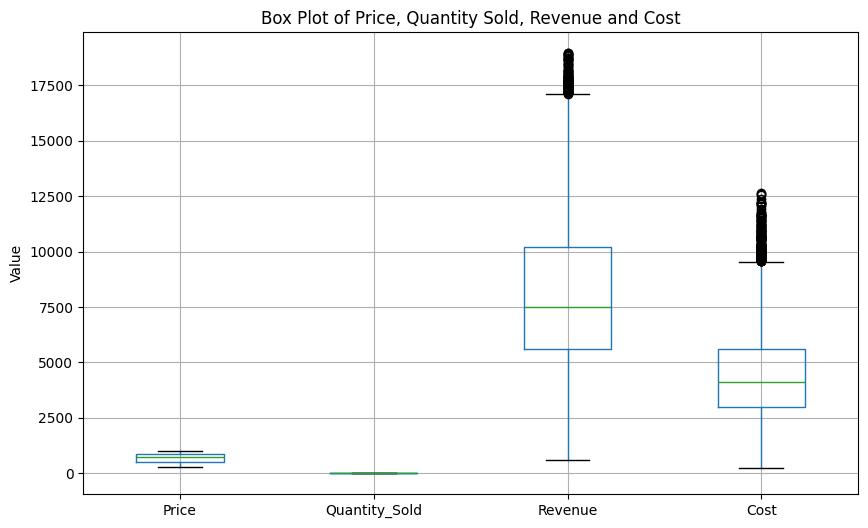

In [126]:
# Box plot.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
outliers.boxplot(column=['Price', 'Quantity_Sold', 'Revenue', 'Cost'])
plt.title('Box Plot of Price, Quantity Sold, Revenue and Cost')
plt.ylabel('Value')
plt.show()


# **Demand Forecasting**

In [127]:
# Preprocess for Time-Series Forecasting.

# Group by region and product category, resample monthly
data_grouped = sales_data.groupby(['Region', 'Category', pd.Grouper(key='Sales_Date', freq='ME')])['Quantity_Sold'].sum().reset_index()

data_grouped

,Region,Category,Sales_Date,Quantity_Sold
0,East,Clothing,2023-01-31,2056
1,East,Clothing,2023-02-28,2084
2,East,Clothing,2023-03-31,2432
3,East,Clothing,2023-04-30,2069
4,East,Clothing,2023-05-31,2179
...,...,...,...,...
235,West,Toys,2023-08-31,2071
236,West,Toys,2023-09-30,2023
237,West,Toys,2023-10-31,2084
238,West,Toys,2023-11-30,1965


In [128]:
# Apply Time-Series Models.

!pip install prophet

In [129]:
from prophet import Prophet

forecasts = {}

# Loop through each region and product category.
for region in data_grouped['Region'].unique():
    for category in data_grouped['Category'].unique():

        # Filtered data for the specific region and category.
        segment_data = data_grouped[(data_grouped['Region'] == region) & (data_grouped['Category'] == category)]

        if segment_data.empty:
            continue

        # Prepared data for Prophet
        df_prophet = segment_data[['Sales_Date', 'Quantity_Sold']].rename(columns={'Sales_Date': 'ds', 'Quantity_Sold': 'y'})

        # Trained the Prophet model
        model = Prophet()
        model.fit(df_prophet)

        # Created future dates for 6 months
        future = model.make_future_dataframe(periods=6, freq='ME')
        forecast = model.predict(future)

        # And save the forecast
        forecasts[(region, category)] = forecast


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmy40u4nk/66nkllus.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmy40u4nk/1s3ango3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67211', 'data', 'file=/tmp/tmpmy40u4nk/66nkllus.json', 'init=/tmp/tmpmy40u4nk/1s3ango3.json', 'output', 'file=/tmp/tmpmy40u4nk/prophet_modelf_tsz__s/prophet_model-20241231131703.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:17:04 - cmdstanpy - INFO - Chain [1] start processing
IN

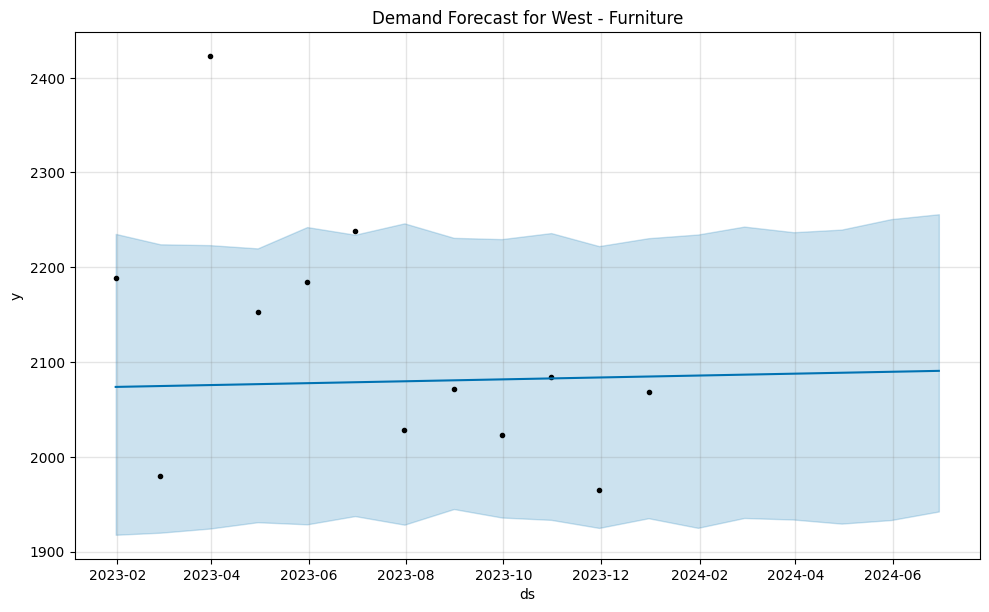

In [130]:
# Plot forecast for a specific region and category

region = 'West'  # Select a single region - 'East', 'South', 'North'
category = 'Furniture' # Select a single category - 'Toys', 'Clothing', 'Sports', 'Electronics'

forecast = forecasts[(region, category)]
model.plot(forecast)
plt.title(f'Demand Forecast for {region} - {category}')
plt.show()


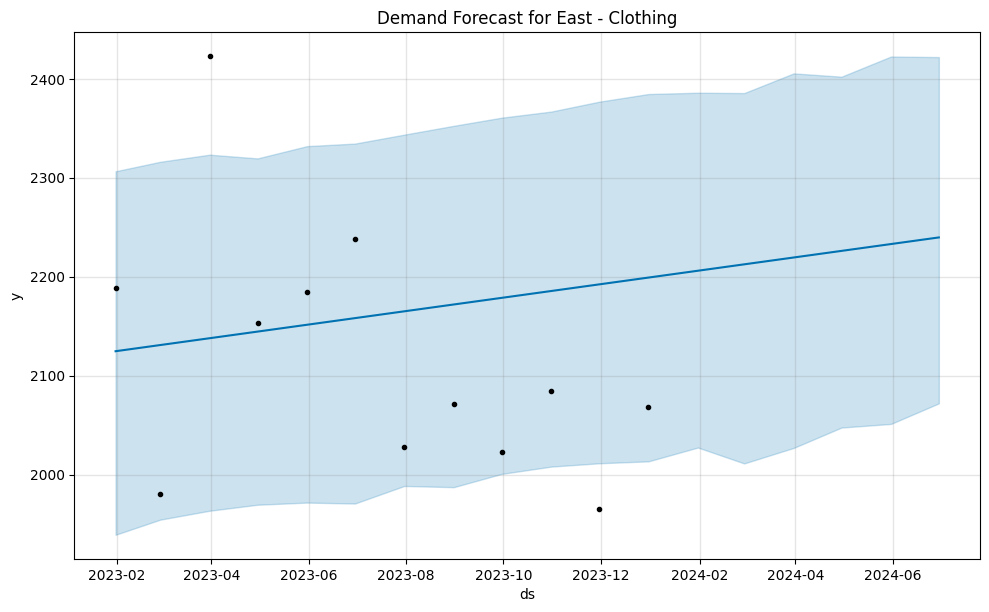

In [131]:
# Plot forecast for a specific region and category
region = 'East'
category = 'Clothing'

forecast = forecasts[(region, category)]
model.plot(forecast)
plt.title(f'Demand Forecast for {region} - {category}')
plt.show()

In [132]:
# Save the forecasts to CSV.

for key, forecast in forecasts.items():
    region, category = key
    filename = f'forecast_{region}_{category}.csv'
    forecast.to_csv(filename, index=False)

# **Optimization Insights**

In [133]:
# Calculated Demand Volatility.

volatility_data = sales_data.groupby('Product_ID')['Quantity_Sold'].agg(['mean', 'std']).reset_index()

# Calculated coefficient of variation (CV)
volatility_data['cv'] = volatility_data['std'] / volatility_data['mean']

# Sorted products by CV in descending order
volatile_products = volatility_data.sort_values(by='cv', ascending=False)


volatile_products.head(10)


,Product_ID,mean,std,cv
7,P0008,9.864801,5.562969,0.563921
19,P0020,9.808350,5.516073,0.562385
11,P0012,9.923108,5.526492,0.556932
18,P0019,9.953245,5.523578,0.554952
10,P0011,10.001596,5.544809,0.554392
0,P0001,9.981651,5.531783,0.554195
12,P0013,9.891828,5.474354,0.553422
6,P0007,9.976753,5.508428,0.552126
1,P0002,9.931627,5.477492,0.551520
4,P0005,9.836430,5.413367,0.550339


**Stocking Strategies**

Based on demand volatility, considered these strategies:

High Volatility Products:                                                                   
        Maintain higher safety stock to buffer against fluctuations.             
        Use flexible ordering systems to adjust quickly to demand.               

Low Volatility Products:                                                      
        Rely on regular replenishment schedules.                            
        Reduce safety stock to minimize holding costs.

In [134]:
# assumptions for lead time and service level.

service_level = 1.65  # 95% service level
lead_time = 2  # A lead time of 2 months

In [135]:
# Calculated Safety Stock for the Top 10 Products.

top_10_products = volatile_products.head(10)

# Calculated safety stock
top_10_products['safety_stock'] = service_level * top_10_products['std'] * (lead_time ** 0.5)

# results
print(top_10_products[['Product_ID', 'mean', 'std', 'cv', 'safety_stock']])


   Product_ID       mean       std        cv  safety_stock
7       P0008   9.864801  5.562969  0.563921     12.980922
19      P0020   9.808350  5.516073  0.562385     12.871493
11      P0012   9.923108  5.526492  0.556932     12.895806
18      P0019   9.953245  5.523578  0.554952     12.889005
10      P0011  10.001596  5.544809  0.554392     12.938548
0       P0001   9.981651  5.531783  0.554195     12.908152
12      P0013   9.891828  5.474354  0.553422     12.774143
6       P0007   9.976753  5.508428  0.552126     12.853654
1       P0002   9.931627  5.477492  0.551520     12.781468
4       P0005   9.836430  5.413367  0.550339     12.631835


**Save the insights to a CSV for reporting and dashboard integration.**

In [136]:
top_10_products.to_csv('safety_stock_top_10_products.csv', index=False)

# **Visualization**

In [137]:
!pip install plotly
!pip install seaborn

In [138]:
!pip install dash

**Historical Demand Trends Visualization**

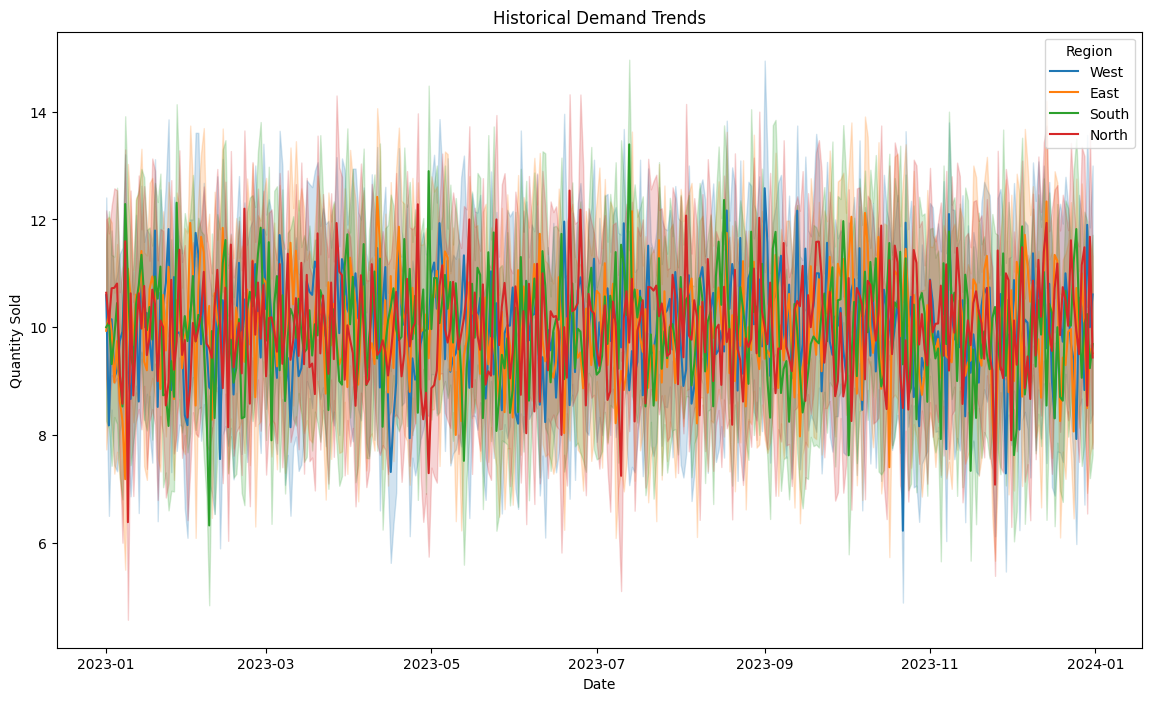

In [139]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Plot historical demand trends
plt.figure(figsize=(14, 8))
fig1 = sns.lineplot(data=sales_data, x='Sales_Date', y='Quantity_Sold', hue='Region')
plt.title('Historical Demand Trends')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.show()


**Forecasted Demand by Region and Product Category**

In [140]:
forecast_data = data_grouped.copy()  # Replace with forecasted data
fig2 = px.line(forecast_data, x='Sales_Date', y='Quantity_Sold', color='Category',
              facet_col='Region', title='Forecasted Demand by Region and Product Category')
fig2.show()


**Inventory Recommendations and Safety Stock Levels**

In [141]:
safety_stock_data = top_10_products[['Product_ID', 'safety_stock']]

fig3 = px.bar(safety_stock_data, x='Product_ID', y='safety_stock',
             title='Safety Stock Levels for Top 10 Products',
             labels={'product_id': 'Product ID', 'safety_stock': 'Safety Stock Level'})
fig3.show()

**Export Data for Tableau**

Historical Demand Trends:

In [142]:
# Aggregate data for historical trends

historical_data = sales_data.groupby(['Sales_Date', 'Region'])['Quantity_Sold'].sum().reset_index()

# Save to CSV
historical_data.to_csv('historical_demand_trends.csv', index=False)


Forecasted Demand:

In [143]:

forecasted_data = []

for (region, category), forecast in forecasts.items():
    forecast['Region'] = region
    forecast['Category'] = category
    forecasted_data.append(forecast)

forecasted_data = pd.concat(forecasted_data)
forecasted_data.to_csv('forecasted_demand.csv', index=False)


Safety Stock Levels:

In [144]:
# Save safety stock data
top_10_products.to_csv('safety_stock_levels.csv', index=False)

In [145]:
# Download files.

from google.colab import files

files.download('historical_demand_trends.csv')
files.download('forecasted_demand.csv')
files.download('safety_stock_levels.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [150]:
!pip install plotly
import plotly.express as px

In [152]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [154]:
import plotly.express as px
fig = px.line(x=[1, 2, 3], y=[4, 5, 6])
fig.show()

In [155]:
from dash import Dash, dcc, html
import plotly.express as px
import pandas as pd

# Load data
historical_data = pd.read_csv('historical_demand_trends.csv')
forecasted_data = pd.read_csv('forecasted_demand.csv')
safety_stock_data = pd.read_csv('safety_stock_levels.csv')

# Create figures
fig1 = px.line(historical_data, x='Sales_Date', y='Quantity_Sold', color='Region',
               title='Historical Demand Trends')

fig2 = px.line(forecasted_data, x='ds', y='yhat', color='Category', facet_col='Region',
               title='Forecasted Demand by Region and Product Category')

fig3 = px.bar(safety_stock_data, x='Product_ID', y='safety_stock',
              title='Safety Stock Levels for Top 10 Products',
              labels={'product_id': 'Product ID', 'safety_stock': 'Safety Stock Level'})

# Create the Dash app
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Inventory Optimization Dashboard"),

    # Historical demand trends
    html.Div([
        html.H2("Historical Demand Trends"),
        dcc.Graph(figure=fig1),
    ]),

    # Forecasted demand
    html.Div([
        html.H2("Forecasted Demand by Region and Product Category"),
        dcc.Graph(figure=fig2),
    ]),

    # Safety stock levels
    html.Div([
        html.H2("Safety Stock Levels"),
        dcc.Graph(figure=fig3),
    ]),
])

if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

In [156]:
!python dashboard.py

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app 'dashboard'
 * Debug mode: on
Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.
